In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

VER = 174
POSTFIX = ''

USE = 'carts'

CT=100

In [2]:
import pandas as pd, cudf, numpy as np, gc
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

In [3]:
users = pd.read_parquet(f'../../data/train_with_features/train_v{VER}.pqt')
print( users.shape )
users.head()

(23388700, 202)


,user,item,pos,wgt,carts,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15
0,11098533,1165015,0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.600000,-1.0,2.200000,-1.0,-1.0,1.500000,1.600000,1.500000,1.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.116279,86.0,58.0,1.482759,0.357067,6.755245,6.755245,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.307692,1.0,-1.0,1.0,-1.0,1.0,-1.0,13.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,7.0,4.750940,4.750940,0.136364,154.0,99.0,56034.429688,321966.906250,1.555556,0.397183,17312.884766,153317.859375,0.250000,16.0,10.0,57562.187500,300562.18750,1.600000,0.577350,22206.015625,82783.578125,10.0,9.0,1.0,2.0,1.000000,1.000000,0.117647,17.0,13.0,38353.824219,373789.125,1.307692,0.332106,15429.47168,13270.989258,40415,1,40414,1.000000,0.987719,0.947001,-1.0,-1.0,-1.0,0.076190,105.0,78.0,56847.656250,318516.218750,1.346154,0.300488,16512.648438,167820.515625,77.0,69.0,1.0,6.0,3.0,6.000000,0.159574,94.0,64.0,67433.125000,314684.18750,1.468750,0.422567,11249.509766,159400.546875,71.0,65.0,2.0,11.0,2.5,2.142857,0.100000,60.0,38.0,38176.464844,333376.468750,1.578947,0.354152,6817.803223,143838.656250,38.0,43.0,1.0,4.0,-1.0,-1.000000,1.0,2.0,2.0,79339.5,338539.5,1.0,0.0,195.868576,195.868576,0.987719,1.0,1.166667,18.0,13.0,62896.667969,336496.656250,1.384615,0.383482,16853.607422,144629.515625,1.333333,3.0,2.0,67674.335938,269274.343750,1.500000,0.577350,24975.738281,24909.345703,1.333333,3.0,2.0,67674.335938,269274.34375,1.5,0.57735,24975.738281,24909.345703,0.117647,17.0,13.0,38353.824219,373789.125,1.307692,0.332106,15429.47168,13270.989258,1.0,2.0,2.0,79339.5,338539.5,1.0,0.0,195.868576,195.868576
1,11098533,385390,1,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.957144,-1.0,1.523522,-1.0,-1.0,0.957144,0.957144,0.957144,0.957144,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.142857,7.0,5.0,1.400000,0.377964,1.154701,1.154701,0.000000,-1.000000,-1.000000,-1.000000,-1

In [4]:
users.user.nunique()

233887

In [5]:
users2 = cudf.DataFrame( users[['user','item']] ).reset_index()
users2.head()

,index,user,item
0,0,11098533,1165015
1,1,11098533,385390
2,2,11098533,978918
3,3,11098533,1074173
4,4,11098533,765030


In [6]:
df = cudf.read_parquet('../../data/train_data/test.parquet')
#MN = df.ts.min()

df = df.sort_values(['session','ts'], ascending=[True,False]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'last_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [7]:
#users2.sample(10)

In [8]:
df = df.sort_values(['session','ts'], ascending=[True,True]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'first_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [9]:
df = df.loc[df['type']>0]
df = df.sort_values(['session','ts'], ascending=[True,False]).reset_index(drop=True)
df['x'] = df.groupby('session').cumcount()

for k in range(5):
    nm = f'buy_{k}'
    tmp = df.loc[df.x==k]
    tmp = tmp[['session','aid']]

    tmp.columns = ['user',nm]

    users2 = users2.merge(tmp,on='user',how='left')
    users2[nm] = users2[nm].fillna(-1)

In [10]:
users2.sample(10)

,index,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4
6674830,6648798,11580346,372931,1708333,529327,740304,1552074,469295,1709859,1490240,1490240,1072655,500601,469295,500601,1490240,-1,-1
17504728,17493480,12443432,1093303,430648,1815856,1815856,897407,1565706,1565706,1565706,897407,1815856,1815856,1815856,1565706,-1,-1,-1
15898280,15948760,12317556,1451504,650351,-1,-1,-1,-1,650351,-1,-1,-1,-1,-1,-1,-1,-1,-1
1408823,1402807,11199920,1127094,601544,1695717,334976,940158,356923,356923,940158,334976,1695717,601544,-1,-1,-1,-1,-1
12782190,12796382,12061075,1369324,45089,1714284,1169323,1223002,1223002,1223002,1223002,1169323,1714284,45089,1223002,-1,-1,-1,-1
7112923,7130043,11618686,152949,1023939,-1,-1,-1,-1,1023939,-1,-1,-1,-1,-1,-1,-1,-1,-1
6734725,6658901,11581135,129259,513932,129259,129259,636390,897254,897254,897254,636390,129259,129259,129259,897254,-1,-1,-1
10268352,10310768,11861823,955838,897928,-1,-1,-1,-1,897928,-1,-1,-1,-1,-1,-1,-1,-1,-1
6437918,6439758,11563994,450342,186256,1062328,126873,996997,1615644,1167444,1689336,479340,357975,1062328,-1,-1,-1,-1,-1
15156947,15166355,12256925,1073795,1003654,1003654,1003654,1003654,1003654,1003654,1003654,1003654,1003654,1003654,1003654,-1,-1,-1,-1


In [11]:
import numpy as np, cupy as cp

def normalize(v):
    if len(v.shape)>1:
        return v / np.sqrt(np.sum(v**2, 1 , keepdims=True))
    else:
        return v / np.sqrt(np.sum(v**2))
   
# WE NEED GIBA EMBEDDINGS HERE
# https://github.com/TheoViel/kaggle_otto_rs/blob/master/notebooks/4-Seq2Seq_Giba.ipynb
try:
    emb = cp.asarray(normalize(np.load('../../data/item_user_features/embbedings_fm10.npy')))
except:
    emb = cp.asarray(normalize(np.load('../../data/item_user_features/item_embed_32.npy')))
emb.shape

(1855603, 256)

In [12]:
def build_dist(a0, a1, BS = 32*256*256):
    global emb
    res = cp.zeros(len(a0))
    for batch in np.arange(0, len(a0), BS):
        emb0 = emb[cp.clip(a0[batch:batch+BS], 0, None)]
        emb1 = emb[cp.clip(a1[batch:batch+BS], 0, None)]
        res[batch:batch+BS] = cp.sum((emb0 * emb1), 1)
    del emb0, emb1
    
    return cp.asnumpy(res)

In [13]:
SHOW_HIST = True

### 0
missing = 0


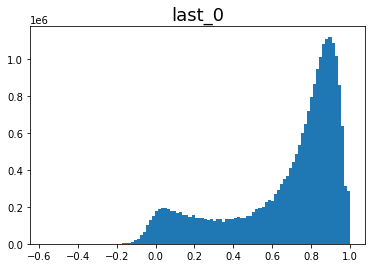

### 1
missing = 5191400


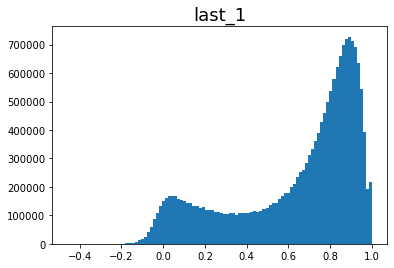

### 2
missing = 9119300


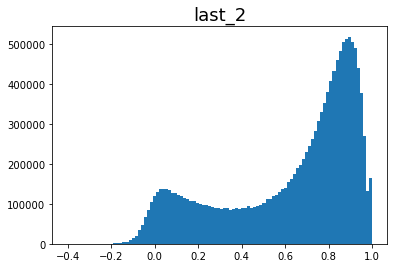

### 3
missing = 11794600


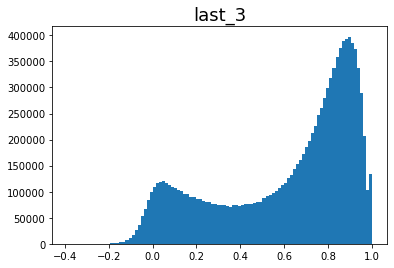

### 4
missing = 13672100


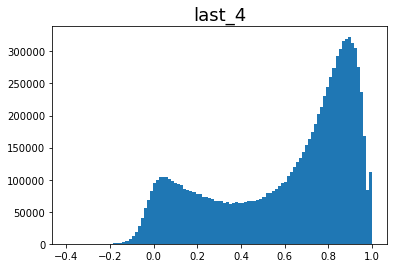

In [14]:
for k in range(5):
    print('###',k)
    nm = f'last_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

### 0
missing = 0


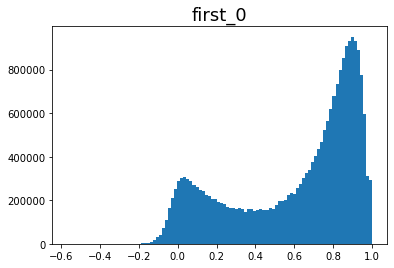

### 1
missing = 5191400


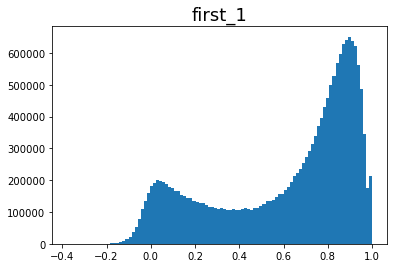

### 2
missing = 9119300


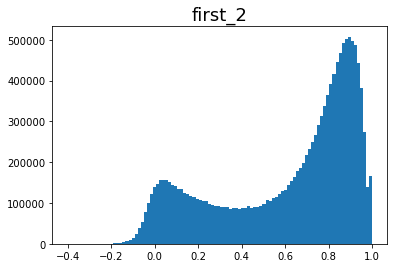

### 3
missing = 11794600


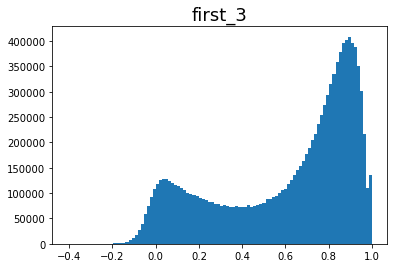

### 4
missing = 13672100


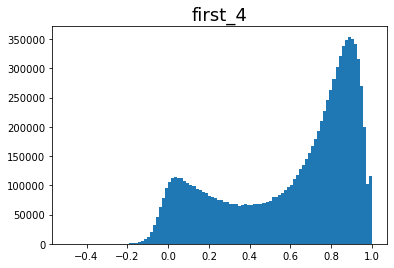

In [15]:
for k in range(5):
    print('###',k)
    nm = f'first_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

### 0
missing = 13368600


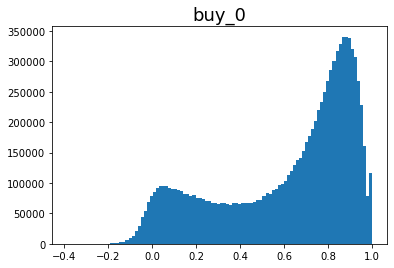

### 1
missing = 17985000


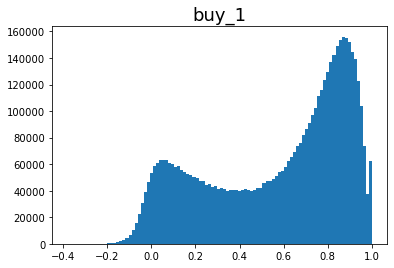

### 2
missing = 20117500


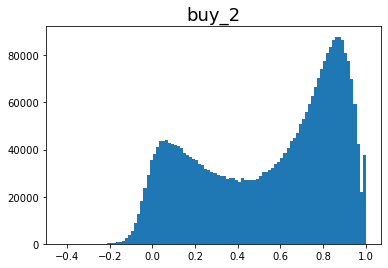

### 3
missing = 21186500


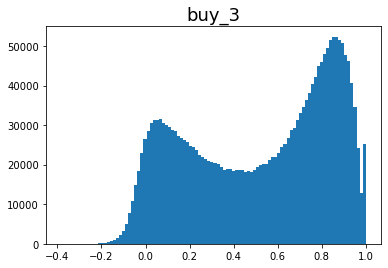

### 4
missing = 21839800


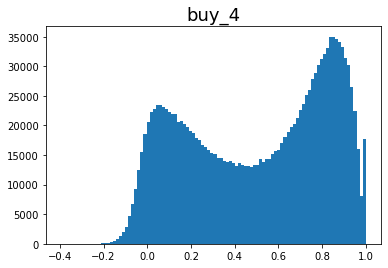

In [16]:
for k in range(5):
    print('###',k)
    nm = f'buy_{k}'
    
    mask = users2[nm] != -1
    print('missing =', len(users2) - mask.sum() )
    
    x = build_dist(users2.item.values, users2[nm].values)
    
    users2.loc[mask,nm] = x[mask.to_numpy()]
    
    if SHOW_HIST:
        plt.hist(x[mask.to_numpy()], bins=100)
        plt.title(nm,size=18)
        plt.show()

In [17]:
users2.head()

,index,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4
0,25456,11099898,176724,0.917680,0.876949,0.926806,0.926806,0.876949,0.876949,0.926806,0.926806,0.876949,0.917680,-1.0,-1.0,-1.0,-1.0,-1.0
1,25457,11099898,168050,0.909441,0.899933,0.930585,0.930585,0.899933,0.899933,0.930585,0.930585,0.899933,0.909441,-1.0,-1.0,-1.0,-1.0,-1.0
2,25458,11099898,21805,0.917183,0.891647,0.947453,0.947453,0.891647,0.891647,0.947453,0.947453,0.891647,0.917183,-1.0,-1.0,-1.0,-1.0,-1.0
3,25459,11099898,1446715,0.877799,0.937844,0.920531,0.920531,0.937844,0.937844,0.920531,0.920531,0.937844,0.877799,-1.0,-1.0,-1.0,-1.0,-1.0
4,25460,11099898,225619,0.177786,0.227756,0.281131,0.281131,0.227756,0.227756,0.281131,0.281131,0.227756,0.177786,-1.0,-1.0,-1.0,-1.0,-1.0


In [18]:
cols1 = [f'last_{x}' for x in range(5)]
cols2 = [f'first_{x}' for x in range(5)]
cols3 = [f'buy_{x}' for x in range(5)]
cols = cols1 + cols2 + cols3
len( cols )

15

In [19]:
for c in cols:
    users2.loc[users2[c]==-1,c] = np.nan

In [20]:
for k,c in enumerate( [cols1,cols2,cols3,cols] ):
    users2[f'e_mean_{k}'] = users2[cols].mean(axis=1)
    users2[f'e_std_{k}'] = users2[cols].std(axis=1)

In [21]:
users2 = users2.fillna(-1)

In [22]:
users2 = users2.sort_values('index').reset_index(drop=True).drop('index',axis=1)

In [23]:
users2.head()

,user,item,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3
0,11098533,1165015,1.000000,0.732554,0.788323,0.805929,0.637763,0.739908,0.805929,0.805929,0.656059,0.756781,0.805929,0.739908,-1.0,-1.0,-1.0,0.772917,0.091530,0.772917,0.091530,0.772917,0.091530,0.772917,0.091530
1,11098533,385390,0.732554,1.000000,0.640626,0.760643,0.553117,0.658647,0.760643,0.760643,0.621339,0.589050,0.760643,0.658647,-1.0,-1.0,-1.0,0.708046,0.117555,0.708046,0.117555,0.708046,0.117555,0.708046,0.117555
2,11098533,978918,0.788323,0.640626,1.000000,0.844681,0.735603,0.803305,0.844681,0.844681,0.582383,0.795453,0.844681,0.803305,-1.0,-1.0,-1.0,0.793977,0.106444,0.793977,0.106444,0.793977,0.106444,0.793977,0.106444
3,11098533,1074173,0.805929,0.760643,0.844681,1.000000,0.729605,0.842716,1.000000,1.000000,0.738797,0.832856,1.000000,0.842716,-1.0,-1.0,-1.0,0.866495,0.106152,0.866495,0.106152,0.866495,0.106152,0.866495,0.106152
4,11098533,765030,0.637763,0.553117,0.735603,0.729605,1.000000,0.866975,0.729605,0.729605,0.577400,0.724429,0.729605,0.866975,-1.0,-1.0,-1.0,0.740057,0.125175,0.740057,0.125175,0.740057,0.125175,0.740057,0.125175


# EDA Columns

In [24]:
for i,c in enumerate(users2.columns):
    if not c in ['user','item']:
        users2[c] = users2[c].astype('float32')
    print(c,users2[c].dtype)

user int32
item int32
last_0 float32
last_1 float32
last_2 float32
last_3 float32
last_4 float32
first_0 float32
first_1 float32
first_2 float32
first_3 float32
first_4 float32
buy_0 float32
buy_1 float32
buy_2 float32
buy_3 float32
buy_4 float32
e_mean_0 float32
e_std_0 float32
e_mean_1 float32
e_std_1 float32
e_mean_2 float32
e_std_2 float32
e_mean_3 float32
e_std_3 float32


In [25]:
for c in users2.columns[:2]:
    print(c,', ',end='')

user , item , 

In [26]:
for c in users2.columns[2:]:
    print(c,', ',end='')
    users[c] = users2[c].to_numpy()
del users2
gc.collect()

last_0 , last_1 , last_2 , last_3 , last_4 , first_0 , first_1 , first_2 , first_3 , first_4 , buy_0 , buy_1 , buy_2 , buy_3 , buy_4 , e_mean_0 , e_std_0 , e_mean_1 , e_std_1 , e_mean_2 , e_std_2 , e_mean_3 , e_std_3 , 

62639

In [27]:
for c in users.columns:
    t = str(users[c].dtype)
    if (t=='int64'): 
        users[c] = users[c].astype('int32')
        print('convert',c,'to int32')
    if (t=='float64')|(t=='Int32')|(t=='Float32'):
        users[c] = users[c].astype('float32')
        print('convert',c,'to float32')

In [28]:
print( users.shape )
users.head()

(23388700, 225)


,user,item,pos,wgt,carts,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10,z10,z11,buy_ratio11,count_item11,count_user11,hour_mean11,day_mean11,repeat11,buy_ratio_std11,hour_std11,day_std11,buy_ratio12,count_item12,count_user12,hour_mean12,day_mean12,repeat12,buy_ratio_std12,hour_std12,day_std12,buy_ratio13,count_item13,count_user13,hour_mean13,day_mean13,repeat13,buy_ratio_std13,hour_std13,day_std13,buy_ratio14,count_item14,unique_item14,hour_mean14,day_mean14,repeat14,buy_ratio_std14,hour_std14,day_std14,buy_ratio15,count_item15,unique_item15,hour_mean15,day_mean15,repeat15,buy_ratio_std15,hour_std15,day_std15,last_0,last_1,last_2,last_3,last_4,first_0,first_1,first_2,first_3,first_4,buy_0,buy_1,buy_2,buy_3,buy_4,e_mean_0,e_std_0,e_mean_1,e_std_1,e_mean_2,e_std_2,e_mean_3,e_std_3
0,11098533,1165015,0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.600000,-1.0,2.200000,-1.0,-1.0,1.500000,1.600000,1.500000,1.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.116279,86.0,58.0,1.482759,0.357067,6.755245,6.755245,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.307692,1.0,-1.0,1.0,-1.0,1.0,-1.0,13.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,7.0,4.750940,4.750940,0.136364,154.0,99.0,56034.429688,321966.906250,1.555556,0.397183,17312.884766,153317.859375,0.250000,16.0,10.0,57562.187500,300562.18750,1.600000,0.577350,22206.015625,82783.578125,10.0,9.0,1.0,2.0,1.000000,1.000000,0.117647,17.0,13.0,38353.824219,373789.125,1.307692,0.332106,15429.47168,13270.989258,40415,1,40414,1.000000,0.987719,0.947001,-1.0,-1.0,-1.0,0.076190,105.0,78.0,56847.656250,318516.218750,1.346154,0.300488,16512.648438,167820.515625,77.0,69.0,1.0,6.0,3.0,6.000000,0.159574,94.0,64.0,67433.125000,314684.18750,1.468750,0.422567,11249.509766,159400.546875,71.0,65.0,2.0,11.0,2.5,2.142857,0.100000,60.0,38.0,38176.464844,333376.468750,1.578947,0.354152,6817.803223,143838.656250,38.0,43.0,1.0,4.0,-1.0,-1.000000,1.0,2.0,2.0,79339.5,338539.5,1.0,0.0,195.868576,195.868576,0.987719,1.0,1.166667,18.0,13.0,62896.667969,336496.656250,1.384615,0.383482,16853.607422,144629.515625,1.333333,3.0,2.0,67674.335938,269274.343750,1.500000,0.577350,24975.738281,24909.345703,1.333333,3.0,2.0,67674.335938,269274.34375,1.5,0.57735,24975.738281,24909.345703,0.117647,17.0,13.0,38353.824219,373789.125,1.307692,0.332106,15429.47168,13270.989258,1.0,2.0,2.0,79339.5,338539.5,1.0,0.0,195.868576,195.868576,1.000000,0.732554,0.788323,0.805929,0.637763,0.739908,0.805929,0.805929,0.656059,0.756781,0.

In [29]:
%%time
users.to_parquet(f'../../data/train_with_features/train_v{VER}.pqt',index=False)

CPU times: user 2min 23s, sys: 5.17 s, total: 2min 28s
Wall time: 1min 50s
